homeowner customer segments
===
# introduction
now let us look at the pet sitters in isolation. we know lots of properties of those:

pet sitter profiles augmented table has a number of useful fields for clustering

considering this highly multidimensional let's explore what groups and grouping are there between them? 

In [1]:
import duckdb
import gower
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from   sklearn.decomposition  import PCA
from   sklearn.metrics        import DistanceMetric
from   sklearn.metrics        import silhouette_score
from   sklearn.preprocessing  import LabelEncoder
from   sklearn_extra.cluster  import KMedoids
import umap
DATABASEFILE='../data/sits.ddb'  # path to persistent duckdb database file
INPROGRESS='../data/inprogress/' # path to folder for caching intermediate data products

In [70]:
sample_no = 3

# fetch data

# reduce size by sampling
calculating the distance matrix of 60k homeowners give 360 million interconncetions. a lot of clarity is lost at a full set. so we sample a random subset of 10k homeowners and cluster the sampler instead. we then repeat the whole process to gauge robustness.

In [71]:
listings_df= pd.read_parquet('../data/listings_prep.parquet').sample(10_000)
# listings_df.info()

In [72]:
# with duckdb.connect(DATABASEFILE) as con:
    # listings_df = con.sql("SELECT * FROM listings_prep").fetchdf()
listings_df.columns, len(listings_df.columns)

(Index(['accessible_by_public_transport', 'avg_nb_apps_per_assg',
        'car_included', 'car_required', 'disabled_access', 'family_friendly',
        'home_type', 'id', 'minutes_pet_can_be_left_alone',
        'nb_assignments_filled', 'nb_assignments_published', 'nb_distinct_pets',
        'nb_domestic_sitters', 'nb_invites', 'nb_of_pets', 'nb_of_photos',
        'nb_repeat_sitters', 'nb_unique_sitters', 'pets_welcome',
        'wish_to_meet_in_person', 'wish_to_video_call', 'other_animals',
        'days_since_modified', 'year_approved', 'attraction_city',
        'attraction_beach', 'attraction_mountain', 'attraction_countryside',
        'pet_dog', 'pet_cat', 'pet_bird', 'pet_fish', 'pet_reptile',
        'pet_poultry', 'pet_farm_animal', 'photo_interior', 'photo_exterior',
        'photo_attraction', 'photo_garden', 'photo_pool', 'photo_view',
        'welcomes_single', 'welcomes_couple', 'welcomes_family',
        'welcomes_any_age', 'welcomes_baby', 'welcomes_toddler',
        

# data preparation

In [73]:
listings_df.dtypes.value_counts()

bool        34
int32       10
Int16        2
int8         1
category     1
int16        1
category     1
Name: count, dtype: int64

In [74]:
categorical_features = list(listings_df.select_dtypes(include=['bool', 'category']).columns)
numerical_features   = list(listings_df.select_dtypes(include=['int8','int16', 'int32',]).columns) 
numerical_features.remove('id') # not using the id as a clustering/segmentation feature

In [75]:
# encoders for categorical variables
encoders = {}
for cat_col in categorical_features:
    if cat_col in listings_df.columns:
        encoders[cat_col] = LabelEncoder()
        listings_df[cat_col] = encoders[cat_col].fit_transform(listings_df[cat_col])


In [76]:
# collect feature columns
feature_columns = []
feature_columns.extend(categorical_features)
feature_columns.extend(numerical_features)
# ensure all features are included in the DataFrame
feature_columns = [col for col in feature_columns if col in listings_df.columns]
# feature type array (1 for categorical, 0 for numeric)
feature_types = [1 if col in categorical_features else 0 for col in feature_columns]


# gower distance matrix calculations

In [77]:
%%time
gower_dist = gower.gower_matrix(listings_df[feature_columns], cat_features=feature_types)

CPU times: user 3min 57s, sys: 28.6 s, total: 4min 26s
Wall time: 4min 26s


In [78]:
gower_dist.shape

(10000, 10000)

In [79]:
# save a copy of the distance matrix
with open(INPROGRESS+'gower_distance_listings.pickle', 'wb+') as fh:
    pickle.dump(gower_dist, fh, protocol=pickle.HIGHEST_PROTOCOL)
# fetch anew 
# with open(NPROGRESS+'gower_distance_listings.pickle', 'rb') as fh:
#     gower_dist=pickle.load(fh)

In [80]:
%%time
# use k-medoids clustering with mixed feature types. optimise the silhouette score to choose k, the number of clusters
sil_scores = []
range_n_clusters = range(2, 9)  # somewhere between 2 and 8 clusters

for n_clusters in range_n_clusters:
    # initialize kmedoids
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', method='pam', init='k-medoids++', random_state=42)
    
    # fit kmedoids to the distance matrix
    kmedoids.fit(gower_dist)
    
    # collect the cluster labels
    cluster_labels = kmedoids.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(gower_dist, cluster_labels, metric='precomputed')
    sil_scores.append(silhouette_avg)
    print(f"for k = {n_clusters}, the kmedoids silhouette score is {silhouette_avg}")


for k = 2, the kmedoids silhouette score is 0.6801153421401978
for k = 3, the kmedoids silhouette score is 0.892041027545929
for k = 4, the kmedoids silhouette score is 0.9031365513801575
for k = 5, the kmedoids silhouette score is 0.7150496244430542
for k = 6, the kmedoids silhouette score is 0.5552074909210205
for k = 7, the kmedoids silhouette score is 0.5351259112358093
for k = 8, the kmedoids silhouette score is 0.5025179982185364
CPU times: user 3min 51s, sys: 837 ms, total: 3min 52s
Wall time: 3min 52s


In [81]:
optimal_n_clusters = range_n_clusters[np.argmax(sil_scores)] # 4 clusters are optimal

optimal number of clusters (by silhouette score): 4


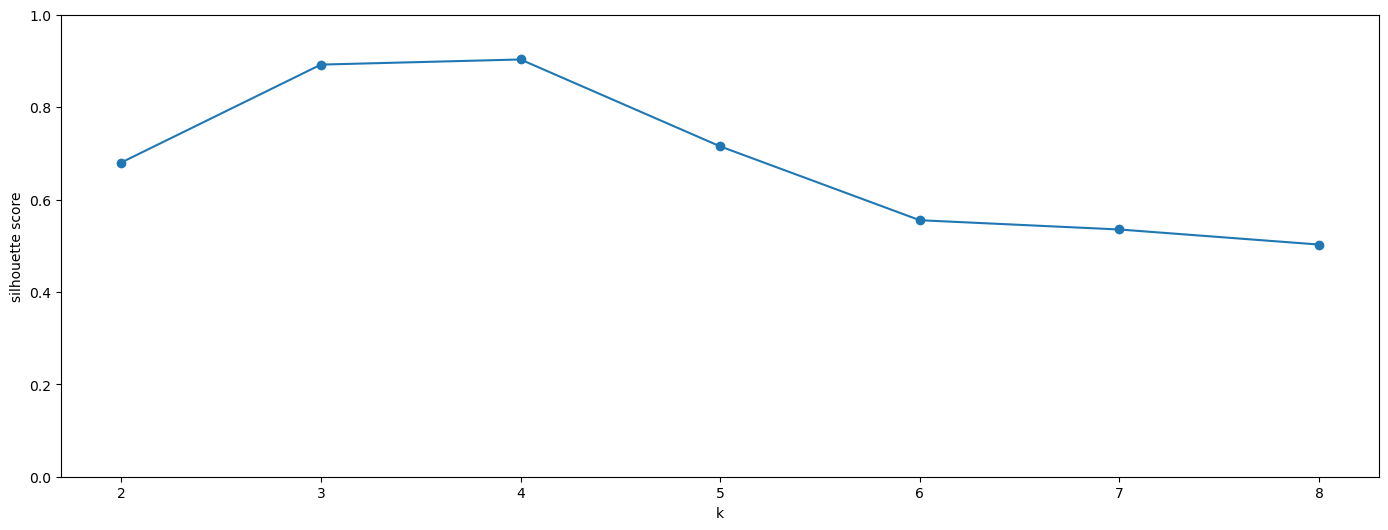

In [82]:
print(f"optimal number of clusters (by silhouette score): {optimal_n_clusters}")
plt.figure(figsize=(17, 6))
plt.plot(range_n_clusters, sil_scores, 'o-')
plt.xlabel('k')
plt.ylabel(f'silhouette score')
plt.ylim((0, 1))
plt.savefig(f'../img/listings_silhuette_{sample_no}.png')
plt.show()

In [83]:
kmedoids = KMedoids(n_clusters=optimal_n_clusters, metric='precomputed', method='pam', init='k-medoids++', random_state=42)
kmedoids.fit(gower_dist)

KMedoids(init='k-medoids++', method='pam', metric='precomputed', n_clusters=4,
         random_state=42)

In [84]:
# save a copy of the kmedoids model
with open(INPROGRESS+'kmedoids_model_listings.pickle', 'wb+') as fh:
    pickle._dump(kmedoids, fh, protocol=pickle.HIGHEST_PROTOCOL)
# fetch anew 
# with open(INPROGRESS+'kmedoids_model_listings.pickle', 'rb') as fh:
#     kmedoids=pickle.load(fh)

In [85]:
# put cluster labels on the sitter profiles
listings_df['cluster'] = kmedoids.labels_

In [86]:
# visualize the clusters using dimensionality reduction
# scaled distance matrix --> similarity matrix
similarity_matrix = 1 - gower_dist

# principal component analysis to reduce dataset to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(similarity_matrix)



In [87]:
# save a copy of the kmedoids model
with open(INPROGRESS+'dim_red_pca.pickle', 'wb+') as fh:
    pickle._dump(pca_result, fh, protocol=pickle.HIGHEST_PROTOCOL)

# fetch anew 
# with open(INPROGRESS+'dim_red_pca.pickle', 'rb') as fh:
#     pca_result=pickle.load(fh)

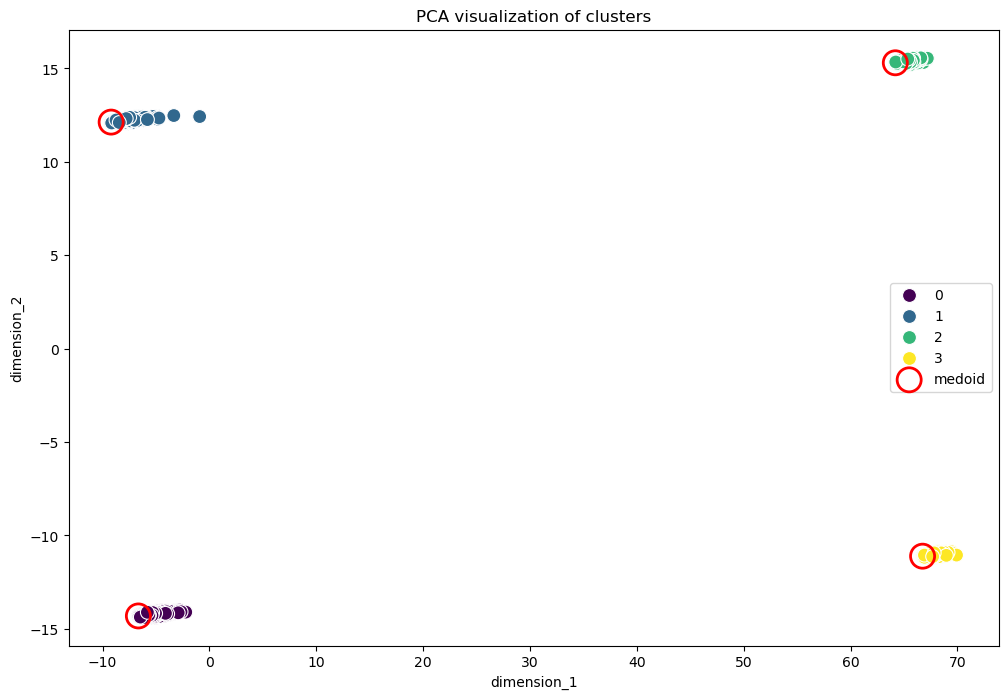

In [67]:
# a dataframe just for plotting
plot_df = pd.DataFrame({
    'dimension_1': pca_result[:, 0],
    'dimension_2': pca_result[:, 1],
    'cluster_label': listings_df['cluster']
})

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='dimension_1', y='dimension_2', hue='cluster_label', data=plot_df, palette='viridis', s=100)
# mark the medoids
for i, medoid_idx in enumerate(kmedoids.medoid_indices_):
    plt.scatter(pca_result[medoid_idx, 0], pca_result[medoid_idx, 1], 
                s=300, linewidth=2, 
                facecolors='none', edgecolors='red',
                label='medoid' if i == 0 else "")
plt.legend()
plt.title('PCA visualization of clusters')

plt.savefig(f'../img/listings_cluster_separation_{sample_no}.png')

plt.show()

- very clean separation of clusters. 

In [89]:
# cluster characteristics
display(listings_df['cluster'].value_counts())

for cluster in range(optimal_n_clusters):
    print('-----------------------------------')
    print(f"cluster {cluster} characteristics:")
    cluster_data = listings_df[listings_df['cluster'] == cluster]
    print(f'cluster contains {len(cluster_data)} homeowner listings')
    
    # feature distribution for categorical features
    for cat_col in categorical_features:
        if cat_col in listings_df.columns:
            print(f"{cat_col} distribution:")
            # back to original categories
            original_values = encoders[cat_col].inverse_transform(cluster_data[cat_col].astype(int))
            value_distribution = pd.Series(original_values).value_counts(normalize=True)
            value_counts       = pd.Series(original_values).value_counts(normalize=False)
            # display(value_counts)
            display(value_distribution)
    
    # For numerical features, show summary statistics
    for num_col in numerical_features:
        if num_col in listings_df.columns:
            print(f"{num_col} statistics:")
            print(cluster_data[num_col].describe())
    print('-----------------------------------')


cluster
2    4816
0    4194
1     499
3     491
Name: count, dtype: int64

-----------------------------------
cluster 0 characteristics:
cluster contains 4194 homeowner listings
accessible_by_public_transport distribution:


False    1.0
Name: proportion, dtype: float64

car_included distribution:


False    1.0
Name: proportion, dtype: float64

car_required distribution:


True     0.927515
False    0.072485
Name: proportion, dtype: float64

disabled_access distribution:


False    0.8598
True     0.1402
Name: proportion, dtype: float64

family_friendly distribution:


False    0.718646
True     0.281354
Name: proportion, dtype: float64

home_type distribution:


house        0.935861
apartment    0.055556
unknown      0.008584
Name: proportion, dtype: float64

pets_welcome distribution:


True     0.811397
False    0.188603
Name: proportion, dtype: float64

wish_to_meet_in_person distribution:


True     0.981879
False    0.018121
Name: proportion, dtype: float64

wish_to_video_call distribution:


True     0.993801
False    0.006199
Name: proportion, dtype: float64

other_animals distribution:


None                                                 0.994278
mallards and reisdent moorhens                       0.000238
doves                                                0.000238
alpacas                                              0.000238
geese & chickens                                     0.000238
guinea pigs                                          0.000238
axolotyl                                             0.000238
steers                                               0.000238
bees                                                 0.000238
must be available for the entire two week period.    0.000238
rabbits                                              0.000238
the kittens are most likely to still be here         0.000238
horses are mini horses. dogs are mini, too           0.000238
mini donkeys                                         0.000238
2 donkeys, 2 head of cattle                          0.000238
4 alpacas                                            0.000238
tortoise

attraction_city distribution:


False    0.650215
True     0.349785
Name: proportion, dtype: float64

attraction_beach distribution:


False    0.761803
True     0.238197
Name: proportion, dtype: float64

attraction_mountain distribution:


False    0.757034
True     0.242966
Name: proportion, dtype: float64

attraction_countryside distribution:


True     0.637339
False    0.362661
Name: proportion, dtype: float64

pet_dog distribution:


True     0.785646
False    0.214354
Name: proportion, dtype: float64

pet_cat distribution:


False    0.549595
True     0.450405
Name: proportion, dtype: float64

pet_bird distribution:


False    0.982356
True     0.017644
Name: proportion, dtype: float64

pet_fish distribution:


False    0.943729
True     0.056271
Name: proportion, dtype: float64

pet_reptile distribution:


False    0.98474
True     0.01526
Name: proportion, dtype: float64

pet_poultry distribution:


False    0.894611
True     0.105389
Name: proportion, dtype: float64

pet_farm_animal distribution:


False    0.970911
True     0.029089
Name: proportion, dtype: float64

photo_interior distribution:


False    0.946113
True     0.053887
Name: proportion, dtype: float64

photo_exterior distribution:


False    0.934669
True     0.065331
Name: proportion, dtype: float64

photo_attraction distribution:


False    0.992847
True     0.007153
Name: proportion, dtype: float64

photo_garden distribution:


False    0.934669
True     0.065331
Name: proportion, dtype: float64

photo_pool distribution:


False    0.99547
True     0.00453
Name: proportion, dtype: float64

photo_view distribution:


False    0.993085
True     0.006915
Name: proportion, dtype: float64

welcomes_single distribution:


True     0.979256
False    0.020744
Name: proportion, dtype: float64

welcomes_couple distribution:


True     0.991416
False    0.008584
Name: proportion, dtype: float64

welcomes_family distribution:


False    0.718646
True     0.281354
Name: proportion, dtype: float64

welcomes_any_age distribution:


True     0.928231
False    0.071769
Name: proportion, dtype: float64

welcomes_baby distribution:


False    0.963519
True     0.036481
Name: proportion, dtype: float64

welcomes_toddler distribution:


False    0.951359
True     0.048641
Name: proportion, dtype: float64

welcomes_child distribution:


False    0.935622
True     0.064378
Name: proportion, dtype: float64

welcomes_teen distribution:


False    0.937053
True     0.062947
Name: proportion, dtype: float64

welcomes_young distribution:


False    0.943014
True     0.056986
Name: proportion, dtype: float64

avg_nb_apps_per_assg statistics:
count    4194.000000
mean        0.304006
std         0.460040
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: avg_nb_apps_per_assg, dtype: float64
minutes_pet_can_be_left_alone statistics:
count    4194.000000
mean      165.894134
std        98.070944
min         0.000000
25%       120.000000
50%       120.000000
75%       120.000000
max       480.000000
Name: minutes_pet_can_be_left_alone, dtype: float64
nb_assignments_filled statistics:
count    4194.000000
mean        5.144731
std         7.288003
min         0.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       129.000000
Name: nb_assignments_filled, dtype: float64
nb_assignments_published statistics:
count    4194.000000
mean        6.259180
std         8.078427
min         0.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       154.000000
Name: nb_assignments_published, dtype: floa

True    1.0
Name: proportion, dtype: float64

car_included distribution:


True    1.0
Name: proportion, dtype: float64

car_required distribution:


False    0.88978
True     0.11022
Name: proportion, dtype: float64

disabled_access distribution:


False    0.793587
True     0.206413
Name: proportion, dtype: float64

family_friendly distribution:


False    0.639279
True     0.360721
Name: proportion, dtype: float64

home_type distribution:


house        0.813627
apartment    0.182365
unknown      0.004008
Name: proportion, dtype: float64

pets_welcome distribution:


True     0.767535
False    0.232465
Name: proportion, dtype: float64

wish_to_meet_in_person distribution:


True     0.971944
False    0.028056
Name: proportion, dtype: float64

wish_to_video_call distribution:


True     0.991984
False    0.008016
Name: proportion, dtype: float64

other_animals distribution:


None                                                     0.989980
rabbits                                                  0.002004
guinea pig                                               0.002004
native magpies                                           0.002004
this is a pet-free home - great if you have allergies    0.002004
1 small bee hive                                         0.002004
Name: proportion, dtype: float64

attraction_city distribution:


True     0.631263
False    0.368737
Name: proportion, dtype: float64

attraction_beach distribution:


False    0.697395
True     0.302605
Name: proportion, dtype: float64

attraction_mountain distribution:


False    0.777555
True     0.222445
Name: proportion, dtype: float64

attraction_countryside distribution:


False    0.579158
True     0.420842
Name: proportion, dtype: float64

pet_dog distribution:


True     0.791583
False    0.208417
Name: proportion, dtype: float64

pet_cat distribution:


False    0.571142
True     0.428858
Name: proportion, dtype: float64

pet_bird distribution:


False    0.987976
True     0.012024
Name: proportion, dtype: float64

pet_fish distribution:


False    0.957916
True     0.042084
Name: proportion, dtype: float64

pet_reptile distribution:


False    0.981964
True     0.018036
Name: proportion, dtype: float64

pet_poultry distribution:


False    0.953908
True     0.046092
Name: proportion, dtype: float64

pet_farm_animal distribution:


False    0.995992
True     0.004008
Name: proportion, dtype: float64

photo_interior distribution:


False    0.92986
True     0.07014
Name: proportion, dtype: float64

photo_exterior distribution:


False    0.917836
True     0.082164
Name: proportion, dtype: float64

photo_attraction distribution:


False    0.991984
True     0.008016
Name: proportion, dtype: float64

photo_garden distribution:


False    0.917836
True     0.082164
Name: proportion, dtype: float64

photo_pool distribution:


False    0.991984
True     0.008016
Name: proportion, dtype: float64

photo_view distribution:


False    0.991984
True     0.008016
Name: proportion, dtype: float64

welcomes_single distribution:


True     0.973948
False    0.026052
Name: proportion, dtype: float64

welcomes_couple distribution:


True     0.97996
False    0.02004
Name: proportion, dtype: float64

welcomes_family distribution:


False    0.639279
True     0.360721
Name: proportion, dtype: float64

welcomes_any_age distribution:


True     0.865731
False    0.134269
Name: proportion, dtype: float64

welcomes_baby distribution:


False    0.917836
True     0.082164
Name: proportion, dtype: float64

welcomes_toddler distribution:


False    0.897796
True     0.102204
Name: proportion, dtype: float64

welcomes_child distribution:


False    0.873747
True     0.126253
Name: proportion, dtype: float64

welcomes_teen distribution:


False    0.885772
True     0.114228
Name: proportion, dtype: float64

welcomes_young distribution:


False    0.8998
True     0.1002
Name: proportion, dtype: float64

avg_nb_apps_per_assg statistics:
count    499.000000
mean       0.326653
std        0.469460
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: avg_nb_apps_per_assg, dtype: float64
minutes_pet_can_be_left_alone statistics:
count    499.000000
mean     194.549098
std      120.650625
min        0.000000
25%      120.000000
50%      120.000000
75%      240.000000
max      480.000000
Name: minutes_pet_can_be_left_alone, dtype: float64
nb_assignments_filled statistics:
count    499.000000
mean       5.775551
std        7.679167
min        0.000000
25%        1.000000
50%        3.000000
75%        8.000000
max       67.000000
Name: nb_assignments_filled, dtype: float64
nb_assignments_published statistics:
count    499.000000
mean       6.853707
std        8.292388
min        0.000000
25%        1.000000
50%        4.000000
75%        9.000000
max       68.000000
Name: nb_assignments_published, dtype: float64
nb_distinct_pets statistics:

True    1.0
Name: proportion, dtype: float64

car_included distribution:


False    1.0
Name: proportion, dtype: float64

car_required distribution:


False    0.912375
True     0.087625
Name: proportion, dtype: float64

disabled_access distribution:


False    0.825581
True     0.174419
Name: proportion, dtype: float64

family_friendly distribution:


False    0.704734
True     0.295266
Name: proportion, dtype: float64

home_type distribution:


house        0.667982
apartment    0.324336
unknown      0.007683
Name: proportion, dtype: float64

pets_welcome distribution:


True     0.740656
False    0.259344
Name: proportion, dtype: float64

wish_to_meet_in_person distribution:


True     0.97799
False    0.02201
Name: proportion, dtype: float64

wish_to_video_call distribution:


True     0.993978
False    0.006022
Name: proportion, dtype: float64

other_animals distribution:


None                                                                                                                                           0.995640
axolotls                                                                                                                                       0.000208
axolotl (mexican walking fish)                                                                                                                 0.000208
wild birds                                                                                                                                     0.000208
parrot                                                                                                                                         0.000208
turtoise                                                                                                                                       0.000208
one african grey parrot                                                                 

attraction_city distribution:


True     0.773879
False    0.226121
Name: proportion, dtype: float64

attraction_beach distribution:


False    0.77554
True     0.22446
Name: proportion, dtype: float64

attraction_mountain distribution:


False    0.889327
True     0.110673
Name: proportion, dtype: float64

attraction_countryside distribution:


False    0.682724
True     0.317276
Name: proportion, dtype: float64

pet_dog distribution:


True     0.630191
False    0.369809
Name: proportion, dtype: float64

pet_cat distribution:


True     0.501869
False    0.498131
Name: proportion, dtype: float64

pet_bird distribution:


False    0.989826
True     0.010174
Name: proportion, dtype: float64

pet_fish distribution:


False    0.957226
True     0.042774
Name: proportion, dtype: float64

pet_reptile distribution:


False    0.985257
True     0.014743
Name: proportion, dtype: float64

pet_poultry distribution:


False    0.97363
True     0.02637
Name: proportion, dtype: float64

pet_farm_animal distribution:


False    0.996055
True     0.003945
Name: proportion, dtype: float64

photo_interior distribution:


False    0.945183
True     0.054817
Name: proportion, dtype: float64

photo_exterior distribution:


False    0.953281
True     0.046719
Name: proportion, dtype: float64

photo_attraction distribution:


False    0.991071
True     0.008929
Name: proportion, dtype: float64

photo_garden distribution:


False    0.953281
True     0.046719
Name: proportion, dtype: float64

photo_pool distribution:


False    0.996678
True     0.003322
Name: proportion, dtype: float64

photo_view distribution:


False    0.996262
True     0.003738
Name: proportion, dtype: float64

welcomes_single distribution:


True     0.986296
False    0.013704
Name: proportion, dtype: float64

welcomes_couple distribution:


True     0.971346
False    0.028654
Name: proportion, dtype: float64

welcomes_family distribution:


False    0.704734
True     0.295266
Name: proportion, dtype: float64

welcomes_any_age distribution:


True     0.903862
False    0.096138
Name: proportion, dtype: float64

welcomes_baby distribution:


False    0.948297
True     0.051703
Name: proportion, dtype: float64

welcomes_toddler distribution:


False    0.931894
True     0.068106
Name: proportion, dtype: float64

welcomes_child distribution:


False    0.91549
True     0.08451
Name: proportion, dtype: float64

welcomes_teen distribution:


False    0.91549
True     0.08451
Name: proportion, dtype: float64

welcomes_young distribution:


False    0.919435
True     0.080565
Name: proportion, dtype: float64

avg_nb_apps_per_assg statistics:
count    4816.000000
mean        0.323920
std         0.468019
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: avg_nb_apps_per_assg, dtype: float64
minutes_pet_can_be_left_alone statistics:
count    4816.000000
mean      188.172757
std       118.906685
min         0.000000
25%       120.000000
50%       120.000000
75%       240.000000
max       480.000000
Name: minutes_pet_can_be_left_alone, dtype: float64
nb_assignments_filled statistics:
count    4816.000000
mean        6.539244
std         8.210909
min         0.000000
25%         1.000000
50%         4.000000
75%         9.000000
max       140.000000
Name: nb_assignments_filled, dtype: float64
nb_assignments_published statistics:
count    4816.000000
mean        7.612542
std         8.805584
min         0.000000
25%         2.000000
50%         5.000000
75%        10.000000
max       143.000000
Name: nb_assignments_published, dtype: floa

False    1.0
Name: proportion, dtype: float64

car_included distribution:


True    1.0
Name: proportion, dtype: float64

car_required distribution:


True     0.94501
False    0.05499
Name: proportion, dtype: float64

disabled_access distribution:


False    0.828921
True     0.171079
Name: proportion, dtype: float64

family_friendly distribution:


False    0.619145
True     0.380855
Name: proportion, dtype: float64

home_type distribution:


house        0.953157
apartment    0.040733
unknown      0.006110
Name: proportion, dtype: float64

pets_welcome distribution:


True     0.814664
False    0.185336
Name: proportion, dtype: float64

wish_to_meet_in_person distribution:


True     0.97556
False    0.02444
Name: proportion, dtype: float64

wish_to_video_call distribution:


True     0.997963
False    0.002037
Name: proportion, dtype: float64

other_animals distribution:


None                             0.979633
ee                               0.002037
tortoise                         0.002037
bird aviary                      0.002037
3 pigs                           0.002037
cats                             0.002037
alpacas                          0.002037
humming bird visitors/nesters    0.002037
giant rabbit                     0.002037
bees                             0.002037
horses                           0.002037
Name: proportion, dtype: float64

attraction_city distribution:


False    0.663951
True     0.336049
Name: proportion, dtype: float64

attraction_beach distribution:


False    0.745418
True     0.254582
Name: proportion, dtype: float64

attraction_mountain distribution:


False    0.682281
True     0.317719
Name: proportion, dtype: float64

attraction_countryside distribution:


True     0.653768
False    0.346232
Name: proportion, dtype: float64

pet_dog distribution:


True     0.798371
False    0.201629
Name: proportion, dtype: float64

pet_cat distribution:


False    0.521385
True     0.478615
Name: proportion, dtype: float64

pet_bird distribution:


False    0.97556
True     0.02444
Name: proportion, dtype: float64

pet_fish distribution:


False    0.94501
True     0.05499
Name: proportion, dtype: float64

pet_reptile distribution:


False    0.98167
True     0.01833
Name: proportion, dtype: float64

pet_poultry distribution:


False    0.881874
True     0.118126
Name: proportion, dtype: float64

pet_farm_animal distribution:


False    0.95723
True     0.04277
Name: proportion, dtype: float64

photo_interior distribution:


False    0.930754
True     0.069246
Name: proportion, dtype: float64

photo_exterior distribution:


False    0.928717
True     0.071283
Name: proportion, dtype: float64

photo_attraction distribution:


False    0.99389
True     0.00611
Name: proportion, dtype: float64

photo_garden distribution:


False    0.928717
True     0.071283
Name: proportion, dtype: float64

photo_pool distribution:


False    0.989817
True     0.010183
Name: proportion, dtype: float64

photo_view distribution:


False    0.995927
True     0.004073
Name: proportion, dtype: float64

welcomes_single distribution:


True     0.973523
False    0.026477
Name: proportion, dtype: float64

welcomes_couple distribution:


True     0.99389
False    0.00611
Name: proportion, dtype: float64

welcomes_family distribution:


False    0.619145
True     0.380855
Name: proportion, dtype: float64

welcomes_any_age distribution:


True     0.88391
False    0.11609
Name: proportion, dtype: float64

welcomes_baby distribution:


False    0.930754
True     0.069246
Name: proportion, dtype: float64

welcomes_toddler distribution:


False    0.916497
True     0.083503
Name: proportion, dtype: float64

welcomes_child distribution:


False    0.892057
True     0.107943
Name: proportion, dtype: float64

welcomes_teen distribution:


False    0.892057
True     0.107943
Name: proportion, dtype: float64

welcomes_young distribution:


False    0.900204
True     0.099796
Name: proportion, dtype: float64

avg_nb_apps_per_assg statistics:
count    491.000000
mean       0.305499
std        0.461088
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: avg_nb_apps_per_assg, dtype: float64
minutes_pet_can_be_left_alone statistics:
count    491.000000
mean     178.167006
std      108.777533
min        0.000000
25%      120.000000
50%      120.000000
75%      240.000000
max      480.000000
Name: minutes_pet_can_be_left_alone, dtype: float64
nb_assignments_filled statistics:
count    491.000000
mean       4.706721
std        5.714601
min        0.000000
25%        1.000000
50%        3.000000
75%        7.000000
max       43.000000
Name: nb_assignments_filled, dtype: float64
nb_assignments_published statistics:
count    491.000000
mean       5.826884
std        6.386894
min        0.000000
25%        1.000000
50%        4.000000
75%        8.000000
max       46.000000
Name: nb_assignments_published, dtype: float64
nb_distinct_pets statistics:

In [ ]:
def calculate_feature_importance(data, cluster_labels, n_clusters=5):
    importances = {}
    
    for cluster in range(n_clusters):
        cluster_data = data[cluster_labels == cluster]
        cluster_size = len(cluster_data)
        total_size = len(data)
        
        feature_importances = {}
        
        for feature in data.columns:
            # For categorical features, look at each category
            if data[feature].dtype == 'object' or data[feature].dtype == 'bool':
                for category in data[feature].unique():
                    # Proportion in cluster with this category
                    prop_in_cluster = (cluster_data[feature] == category).mean()
                    # Proportion in overall dataset with this category
                    prop_overall = (data[feature] == category).mean()
                    
                    # Avoid division by zero
                    if prop_overall > 0:
                        # Lift/importance score
                        importance = prop_in_cluster / prop_overall
                        feature_importances[f"{feature}_{category}"] = importance
            
        # Sort by importance (descending)
        sorted_importances = dict(sorted(feature_importances.items(), 
                                        key=lambda x: abs(x[1]-1), 
                                        reverse=True))
        importances[f"Cluster_{cluster}"] = sorted_importances
    
    return importances


In [ ]:
# import umap.umap_ as umap
# reducer = umap.UMAP()


- NTF: number of dims in which the first value is True, second is False = 2.
- NFT: number of dims in which the first value is False, second is True = 1.
- NNEQ : number of non-equal dimensions, NNEQ = NTF + NFT = 3.
- NTT : number of dims in which both values are True = 0.
- NNZ : number of nonzero dimensions, NNZ = NTF + NFT + NTT = 3.
- DiceDistance = NNEQ / (NTT + NNZ) = 3/3 = 1